In [1]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
from jinja2.optimizer import optimize
from keras import layers
from numpy.f2py.rules import options
from tensorflow.keras.applications import EfficientNetB0

2025-03-30 10:26:43.476221: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-30 10:26:43.489758: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743326803.503755    5213 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743326803.507884    5213 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743326803.518601    5213 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
image_size = 224
batch_size = 32

dataset_name = "stanford_dogs"
(ds_train, ds_test), ds_info = tfds.load(dataset_name,
                                         split=["train", "test"],
                                         with_info=True,
                                         as_supervised=True)
NUM_CLASSES = ds_info.features['label'].num_classes

I0000 00:00:1743326809.357339    5213 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9711 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


KeyboardInterrupt: 

In [5]:
size = (image_size, image_size)
ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))
ds_test = ds_test.map(lambda image, label: (tf.image.resize(image, size), label))



2025-03-29 19:27:57.508584: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-03-29 19:27:57.615053: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


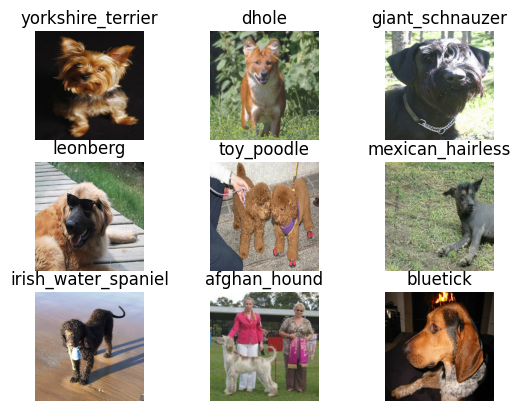

In [6]:
def format_image(label):
    return label_info.int2str(label).split('-')[1]

label_info = ds_info.features['label']

for i, (image, label) in enumerate(ds_train.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype('uint8'))
    plt.title("{}".format(format_image(label)))
    plt.axis('off')




In [7]:
img_augmentatiom_layers = [
    layers.RandomRotation(factor=0.15),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomFlip(),
    layers.RandomContrast(factor=0.1),
]

def img_augmentation(images):
    for aug in img_augmentatiom_layers:
        images = aug(images)
    return images

2025-03-29 19:28:04.082274: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


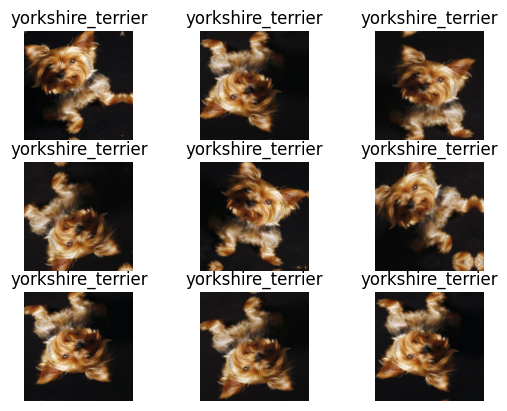

In [8]:
for image, label in ds_train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        aug_image = img_augmentation(np.expand_dims(image.numpy(), axis=0))
        aug_image = np.array(aug_image)
        plt.imshow(aug_image[0].astype('uint8'))
        plt.title("{}".format(format_image(label)))
        plt.axis('off')

In [9]:
def input_prepeocess_train(image, label):
    return img_augmentation(image), tf.one_hot(label, NUM_CLASSES)

def input_prepeocess_test(image, label):
    return image, tf.one_hot(label, NUM_CLASSES)


ds_train = ds_train.map(input_prepeocess_train, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.batch(batch_size=batch_size, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(input_prepeocess_test, num_parallel_calls = tf.data.AUTOTUNE)
ds_test = ds_test.batch(batch_size=batch_size, drop_remainder=True)

In [10]:
model = EfficientNetB0(
    include_top=True,
    weights=None,
    classes=NUM_CLASSES,
    input_shape=(image_size, image_size, 3),
)

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

model.summary()

Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ normalization[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │         64 │ block1a_project_

 Total params: 4,203,291 (16.03 MB)

 Trainable params: 4,161,268 (15.87 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [11]:
epochs = 40
hist = model.fit(
    ds_train,
    epochs=epochs,
    validation_data=ds_test,
)

Epoch 1/40


I0000 00:00:1743276503.836214   65527 service.cc:152] XLA service 0x55dca91321f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743276503.836256   65527 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-03-29 19:28:24.336425: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1743276506.587544   65527 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1743276530.718527   65527 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.0104 - loss: 5.0412

2025-03-29 19:29:27.896482: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2068_0', 328 bytes spill stores, 980 bytes spill loads

2025-03-29 19:29:28.079672: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2068', 244 bytes spill stores, 244 bytes spill loads

2025-03-29 19:29:28.310977: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2068', 5280 bytes spill stores, 5244 bytes spill loads

2025-03-29 19:29:28.377555: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2068', 5336 bytes spill stores, 5356 bytes spill loads



375/375 ━━━━━━━━━━━━━━━━━━━━ 84s 120ms/step - accuracy: 0.0104 - loss: 5.0408 - val_accuracy: 0.0125 - val_loss: 4.8867
Epoch 2/40
  1/375 ━━━━━━━━━━━━━━━━━━━━ 1:25 229ms/step - accuracy: 0.0000e+00 - loss: 4.7594

2025-03-29 19:29:36.111637: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33569792 bytes after encountering the first element of size 33569792 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


375/375 ━━━━━━━━━━━━━━━━━━━━ 41s 109ms/step - accuracy: 0.0228 - loss: 4.6117 - val_accuracy: 0.0285 - val_loss: 4.4955
Epoch 3/40
  2/375 ━━━━━━━━━━━━━━━━━━━━ 36s 98ms/step - accuracy: 0.0156 - loss: 4.5134      

2025-03-29 19:30:16.928909: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33569792 bytes after encountering the first element of size 33569792 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


375/375 ━━━━━━━━━━━━━━━━━━━━ 42s 112ms/step - accuracy: 0.0329 - loss: 4.4208 - val_accuracy: 0.0415 - val_loss: 4.3877
Epoch 4/40
  1/375 ━━━━━━━━━━━━━━━━━━━━ 1:14 201ms/step - accuracy: 0.0625 - loss: 4.2698

2025-03-29 19:30:58.879930: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33569792 bytes after encountering the first element of size 33569792 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


375/375 ━━━━━━━━━━━━━━━━━━━━ 41s 110ms/step - accuracy: 0.0433 - loss: 4.2916 - val_accuracy: 0.0517 - val_loss: 4.2329
Epoch 5/40
  2/375 ━━━━━━━━━━━━━━━━━━━━ 42s 113ms/step - accuracy: 0.0469 - loss: 4.1465 

2025-03-29 19:31:40.180957: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33569792 bytes after encountering the first element of size 33569792 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


375/375 ━━━━━━━━━━━━━━━━━━━━ 42s 111ms/step - accuracy: 0.0536 - loss: 4.1890 - val_accuracy: 0.0416 - val_loss: 4.4574
Epoch 6/40
  1/375 ━━━━━━━━━━━━━━━━━━━━ 1:14 200ms/step - accuracy: 0.0312 - loss: 4.0159

2025-03-29 19:32:21.995412: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33569792 bytes after encountering the first element of size 33569792 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


375/375 ━━━━━━━━━━━━━━━━━━━━ 41s 110ms/step - accuracy: 0.0611 - loss: 4.1066 - val_accuracy: 0.0554 - val_loss: 4.1752
Epoch 7/40
  1/375 ━━━━━━━━━━━━━━━━━━━━ 1:16 205ms/step - accuracy: 0.0625 - loss: 4.0293

2025-03-29 19:33:03.494013: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33569792 bytes after encountering the first element of size 33569792 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


375/375 ━━━━━━━━━━━━━━━━━━━━ 41s 108ms/step - accuracy: 0.0712 - loss: 4.0166 - val_accuracy: 0.0529 - val_loss: 4.2900
Epoch 8/40
  2/375 ━━━━━━━━━━━━━━━━━━━━ 39s 106ms/step - accuracy: 0.1172 - loss: 3.9178 

2025-03-29 19:33:44.276741: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33569792 bytes after encountering the first element of size 33569792 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


375/375 ━━━━━━━━━━━━━━━━━━━━ 42s 113ms/step - accuracy: 0.0766 - loss: 3.9384 - val_accuracy: 0.0556 - val_loss: 4.2233
Epoch 9/40
  2/375 ━━━━━━━━━━━━━━━━━━━━ 39s 105ms/step - accuracy: 0.1484 - loss: 3.8556 

2025-03-29 19:34:26.720636: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33569792 bytes after encountering the first element of size 33569792 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


375/375 ━━━━━━━━━━━━━━━━━━━━ 43s 113ms/step - accuracy: 0.0874 - loss: 3.8717 - val_accuracy: 0.0647 - val_loss: 4.2198
Epoch 10/40
  1/375 ━━━━━━━━━━━━━━━━━━━━ 1:38 262ms/step - accuracy: 0.0625 - loss: 3.8459

2025-03-29 19:35:09.380964: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33569792 bytes after encountering the first element of size 33569792 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


375/375 ━━━━━━━━━━━━━━━━━━━━ 42s 110ms/step - accuracy: 0.1062 - loss: 3.7605 - val_accuracy: 0.0739 - val_loss: 4.2576
Epoch 11/40
  1/375 ━━━━━━━━━━━━━━━━━━━━ 1:15 203ms/step - accuracy: 0.1562 - loss: 3.6071

2025-03-29 19:35:50.837879: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33569792 bytes after encountering the first element of size 33569792 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


375/375 ━━━━━━━━━━━━━━━━━━━━ 42s 111ms/step - accuracy: 0.1210 - loss: 3.6668 - val_accuracy: 0.0968 - val_loss: 3.8845
Epoch 12/40
  1/375 ━━━━━━━━━━━━━━━━━━━━ 1:13 197ms/step - accuracy: 0.2188 - loss: 3.6208

2025-03-29 19:36:32.696591: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33569792 bytes after encountering the first element of size 33569792 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


375/375 ━━━━━━━━━━━━━━━━━━━━ 42s 112ms/step - accuracy: 0.1312 - loss: 3.5774 - val_accuracy: 0.0974 - val_loss: 3.9484
Epoch 13/40
  1/375 ━━━━━━━━━━━━━━━━━━━━ 1:18 209ms/step - accuracy: 0.2188 - loss: 3.5795

2025-03-29 19:37:14.691369: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33569792 bytes after encountering the first element of size 33569792 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


375/375 ━━━━━━━━━━━━━━━━━━━━ 41s 109ms/step - accuracy: 0.1467 - loss: 3.4941 - val_accuracy: 0.1300 - val_loss: 3.6796
Epoch 14/40
  1/375 ━━━━━━━━━━━━━━━━━━━━ 1:17 207ms/step - accuracy: 0.2500 - loss: 3.5989

2025-03-29 19:37:55.620005: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33569792 bytes after encountering the first element of size 33569792 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


375/375 ━━━━━━━━━━━━━━━━━━━━ 41s 110ms/step - accuracy: 0.1631 - loss: 3.4242 - val_accuracy: 0.1146 - val_loss: 3.9199
Epoch 15/40
  1/375 ━━━━━━━━━━━━━━━━━━━━ 1:19 212ms/step - accuracy: 0.1875 - loss: 3.3936

2025-03-29 19:38:36.803029: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33569792 bytes after encountering the first element of size 33569792 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


375/375 ━━━━━━━━━━━━━━━━━━━━ 43s 113ms/step - accuracy: 0.1786 - loss: 3.3256 - val_accuracy: 0.1475 - val_loss: 3.5656
Epoch 16/40
  2/375 ━━━━━━━━━━━━━━━━━━━━ 38s 104ms/step - accuracy: 0.1797 - loss: 3.2573 

2025-03-29 19:39:19.467696: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33569792 bytes after encountering the first element of size 33569792 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


375/375 ━━━━━━━━━━━━━━━━━━━━ 42s 110ms/step - accuracy: 0.1937 - loss: 3.2453 - val_accuracy: 0.1613 - val_loss: 3.4638
Epoch 17/40
  1/375 ━━━━━━━━━━━━━━━━━━━━ 1:16 204ms/step - accuracy: 0.1875 - loss: 3.5494

2025-03-29 19:40:00.976081: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33569792 bytes after encountering the first element of size 33569792 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


375/375 ━━━━━━━━━━━━━━━━━━━━ 48s 127ms/step - accuracy: 0.2069 - loss: 3.1723 - val_accuracy: 0.1490 - val_loss: 3.6350
Epoch 18/40
  1/375 ━━━━━━━━━━━━━━━━━━━━ 1:19 213ms/step - accuracy: 0.1875 - loss: 3.5709

2025-03-29 19:40:48.723344: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33569792 bytes after encountering the first element of size 33569792 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


375/375 ━━━━━━━━━━━━━━━━━━━━ 42s 112ms/step - accuracy: 0.2200 - loss: 3.1125 - val_accuracy: 0.1659 - val_loss: 3.5139
Epoch 19/40
  2/375 ━━━━━━━━━━━━━━━━━━━━ 39s 106ms/step - accuracy: 0.2344 - loss: 3.2267 

2025-03-29 19:41:30.745397: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33569792 bytes after encountering the first element of size 33569792 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


375/375 ━━━━━━━━━━━━━━━━━━━━ 43s 114ms/step - accuracy: 0.2278 - loss: 3.0369 - val_accuracy: 0.1872 - val_loss: 3.3774
Epoch 20/40
  1/375 ━━━━━━━━━━━━━━━━━━━━ 1:19 212ms/step - accuracy: 0.1562 - loss: 3.0891

2025-03-29 19:42:13.427070: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33569792 bytes after encountering the first element of size 33569792 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


375/375 ━━━━━━━━━━━━━━━━━━━━ 43s 114ms/step - accuracy: 0.2422 - loss: 2.9657 - val_accuracy: 0.1769 - val_loss: 3.4577
Epoch 21/40
  1/375 ━━━━━━━━━━━━━━━━━━━━ 1:20 216ms/step - accuracy: 0.2188 - loss: 3.3208

2025-03-29 19:42:56.234182: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33569792 bytes after encountering the first element of size 33569792 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


375/375 ━━━━━━━━━━━━━━━━━━━━ 42s 111ms/step - accuracy: 0.2575 - loss: 2.8696 - val_accuracy: 0.1916 - val_loss: 3.3440
Epoch 22/40
  1/375 ━━━━━━━━━━━━━━━━━━━━ 1:20 215ms/step - accuracy: 0.2500 - loss: 3.1177

2025-03-29 19:43:38.108997: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33569792 bytes after encountering the first element of size 33569792 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


375/375 ━━━━━━━━━━━━━━━━━━━━ 42s 112ms/step - accuracy: 0.2755 - loss: 2.7941 - val_accuracy: 0.2044 - val_loss: 3.3345
Epoch 23/40
  2/375 ━━━━━━━━━━━━━━━━━━━━ 40s 108ms/step - accuracy: 0.3047 - loss: 2.8052 

2025-03-29 19:44:20.126775: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33569792 bytes after encountering the first element of size 33569792 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


375/375 ━━━━━━━━━━━━━━━━━━━━ 42s 112ms/step - accuracy: 0.2882 - loss: 2.7391 - val_accuracy: 0.1860 - val_loss: 3.4552
Epoch 24/40
  1/375 ━━━━━━━━━━━━━━━━━━━━ 1:16 205ms/step - accuracy: 0.2188 - loss: 2.8564

2025-03-29 19:45:02.363329: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33569792 bytes after encountering the first element of size 33569792 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


375/375 ━━━━━━━━━━━━━━━━━━━━ 43s 114ms/step - accuracy: 0.2976 - loss: 2.6645 - val_accuracy: 0.1926 - val_loss: 3.4829
Epoch 25/40
  1/375 ━━━━━━━━━━━━━━━━━━━━ 1:20 215ms/step - accuracy: 0.2188 - loss: 3.1063

2025-03-29 19:45:45.276159: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33569792 bytes after encountering the first element of size 33569792 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


375/375 ━━━━━━━━━━━━━━━━━━━━ 43s 114ms/step - accuracy: 0.3122 - loss: 2.5904 - val_accuracy: 0.1927 - val_loss: 3.5397
Epoch 26/40
  2/375 ━━━━━━━━━━━━━━━━━━━━ 40s 108ms/step - accuracy: 0.1953 - loss: 2.7985 

2025-03-29 19:46:28.006943: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33569792 bytes after encountering the first element of size 33569792 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


375/375 ━━━━━━━━━━━━━━━━━━━━ 42s 112ms/step - accuracy: 0.3285 - loss: 2.5226 - val_accuracy: 0.2122 - val_loss: 3.3987
Epoch 27/40
  1/375 ━━━━━━━━━━━━━━━━━━━━ 1:22 220ms/step - accuracy: 0.3438 - loss: 2.9397

2025-03-29 19:47:10.295056: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33569792 bytes after encountering the first element of size 33569792 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


375/375 ━━━━━━━━━━━━━━━━━━━━ 42s 113ms/step - accuracy: 0.3440 - loss: 2.4541 - val_accuracy: 0.2194 - val_loss: 3.3520
Epoch 28/40
  2/375 ━━━━━━━━━━━━━━━━━━━━ 39s 106ms/step - accuracy: 0.3125 - loss: 2.7576 

2025-03-29 19:47:52.680934: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33569792 bytes after encountering the first element of size 33569792 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


375/375 ━━━━━━━━━━━━━━━━━━━━ 42s 111ms/step - accuracy: 0.3644 - loss: 2.3887 - val_accuracy: 0.2111 - val_loss: 3.4417
Epoch 29/40
  1/375 ━━━━━━━━━━━━━━━━━━━━ 1:19 212ms/step - accuracy: 0.3438 - loss: 2.6495

2025-03-29 19:48:34.398373: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33569792 bytes after encountering the first element of size 33569792 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


375/375 ━━━━━━━━━━━━━━━━━━━━ 42s 112ms/step - accuracy: 0.3788 - loss: 2.2629 - val_accuracy: 0.1778 - val_loss: 3.7250
Epoch 30/40
  1/375 ━━━━━━━━━━━━━━━━━━━━ 1:20 215ms/step - accuracy: 0.3750 - loss: 2.5209

2025-03-29 19:49:16.577739: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33569792 bytes after encountering the first element of size 33569792 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


375/375 ━━━━━━━━━━━━━━━━━━━━ 43s 115ms/step - accuracy: 0.3938 - loss: 2.2189 - val_accuracy: 0.2125 - val_loss: 3.4918
Epoch 31/40
  1/375 ━━━━━━━━━━━━━━━━━━━━ 1:15 203ms/step - accuracy: 0.4062 - loss: 2.3408

2025-03-29 19:49:59.787803: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33569792 bytes after encountering the first element of size 33569792 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


375/375 ━━━━━━━━━━━━━━━━━━━━ 42s 112ms/step - accuracy: 0.4171 - loss: 2.1026 - val_accuracy: 0.2194 - val_loss: 3.5199
Epoch 32/40
  1/375 ━━━━━━━━━━━━━━━━━━━━ 1:18 210ms/step - accuracy: 0.3438 - loss: 2.3883

2025-03-29 19:50:42.056642: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33569792 bytes after encountering the first element of size 33569792 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


375/375 ━━━━━━━━━━━━━━━━━━━━ 42s 113ms/step - accuracy: 0.4275 - loss: 2.0601 - val_accuracy: 0.2450 - val_loss: 3.3836
Epoch 33/40
  2/375 ━━━━━━━━━━━━━━━━━━━━ 38s 104ms/step - accuracy: 0.4062 - loss: 2.3317 

2025-03-29 19:51:24.406080: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33569792 bytes after encountering the first element of size 33569792 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


375/375 ━━━━━━━━━━━━━━━━━━━━ 42s 111ms/step - accuracy: 0.4498 - loss: 1.9596 - val_accuracy: 0.2566 - val_loss: 3.4204
Epoch 34/40
  2/375 ━━━━━━━━━━━━━━━━━━━━ 39s 107ms/step - accuracy: 0.4766 - loss: 2.1591 

2025-03-29 19:52:06.237737: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33569792 bytes after encountering the first element of size 33569792 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


375/375 ━━━━━━━━━━━━━━━━━━━━ 42s 113ms/step - accuracy: 0.4781 - loss: 1.8672 - val_accuracy: 0.2172 - val_loss: 3.7155
Epoch 35/40
  1/375 ━━━━━━━━━━━━━━━━━━━━ 1:17 208ms/step - accuracy: 0.5000 - loss: 2.1227

2025-03-29 19:52:48.588769: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33569792 bytes after encountering the first element of size 33569792 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


375/375 ━━━━━━━━━━━━━━━━━━━━ 42s 112ms/step - accuracy: 0.4949 - loss: 1.7981 - val_accuracy: 0.2243 - val_loss: 3.8087
Epoch 36/40
  1/375 ━━━━━━━━━━━━━━━━━━━━ 1:17 208ms/step - accuracy: 0.5000 - loss: 1.9983

2025-03-29 19:53:30.841728: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33569792 bytes after encountering the first element of size 33569792 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


375/375 ━━━━━━━━━━━━━━━━━━━━ 42s 111ms/step - accuracy: 0.5109 - loss: 1.7211 - val_accuracy: 0.2274 - val_loss: 3.7821
Epoch 37/40
  2/375 ━━━━━━━━━━━━━━━━━━━━ 39s 105ms/step - accuracy: 0.5000 - loss: 1.7630 

2025-03-29 19:54:12.618186: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33569792 bytes after encountering the first element of size 33569792 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


375/375 ━━━━━━━━━━━━━━━━━━━━ 43s 113ms/step - accuracy: 0.5343 - loss: 1.6341 - val_accuracy: 0.2396 - val_loss: 3.8212
Epoch 38/40
  1/375 ━━━━━━━━━━━━━━━━━━━━ 1:17 208ms/step - accuracy: 0.5625 - loss: 1.8122

2025-03-29 19:54:55.216011: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33569792 bytes after encountering the first element of size 33569792 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


375/375 ━━━━━━━━━━━━━━━━━━━━ 43s 113ms/step - accuracy: 0.5485 - loss: 1.5573 - val_accuracy: 0.2399 - val_loss: 3.8742
Epoch 39/40
  1/375 ━━━━━━━━━━━━━━━━━━━━ 1:16 204ms/step - accuracy: 0.5938 - loss: 1.4372

2025-03-29 19:55:37.799741: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33569792 bytes after encountering the first element of size 33569792 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


375/375 ━━━━━━━━━━━━━━━━━━━━ 42s 112ms/step - accuracy: 0.5792 - loss: 1.4408 - val_accuracy: 0.2162 - val_loss: 4.2206
Epoch 40/40
  1/375 ━━━━━━━━━━━━━━━━━━━━ 1:21 217ms/step - accuracy: 0.5625 - loss: 1.8025

2025-03-29 19:56:20.022676: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33569792 bytes after encountering the first element of size 33569792 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


375/375 ━━━━━━━━━━━━━━━━━━━━ 46s 122ms/step - accuracy: 0.5944 - loss: 1.3905 - val_accuracy: 0.2392 - val_loss: 3.9554
